# SETUP

In [411]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# For reading stock data from yahoo
from pandas_datareader.data import DataReader
import yfinance as yf

# For time stamps
from datetime import datetime


from pathlib import Path
from warnings import simplefilter
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

from sklearn.model_selection import train_test_split
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from xgboost import XGBRegressor



# LOAD DATA

In [412]:
# The tech stocks we'll use for this analysis
tech_list = ['AAPL', 'GOOG', 'TSLA', 'AMZN']

# Set up End and Start times for data grab
tech_list = ['AAPL', 'GOOG', 'TSLA', 'AMZN']

start = '2016-01-01'
end = '2021-12-30'

for stock in tech_list:
    globals()[stock] = yf.download(stock, start, end)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [413]:
company_list = [AAPL, GOOG, TSLA, AMZN]
company_name = ["APPLE", "GOOGLE", "TESLA", "AMAZON"]

for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name
    
df = pd.concat(company_list, axis=0)
df.tail(10)

,Open,High,Low,Close,Adj Close,Volume,company_name
Date,,,,,,,
2021-12-15,168.598007,173.600006,165.195007,173.315002,173.315002,75794000,AMAZON
2021-12-16,173.368500,174.166000,168.160507,168.871002,168.871002,60876000,AMAZON
2021-12-17,167.710495,170.898499,165.613495,170.017502,170.017502,85542000,AMAZON
2021-12-20,166.850006,167.874496,165.600006,167.078995,167.078995,57372000,AMAZON
2021-12-21,167.850494,170.716507,165.647507,170.417007,170.417007,55956000,AMAZON
2021-12-22,169.270004,172.050003,168.500504,171.037003,171.037003,55036000,AMAZON
2021-12-23,170.427994,171.975006,170.149994,171.068497,171.068497,36788000,AMAZON
2021-12-27,171.037003,172.942993,169.215500,169.669495,169.669495,58688000,AMAZON
2021-12-28,170.182495,172.175995,169.135498,170.660995,170.660995,54638000,AMAZON


In [414]:
# Summary Stats
AAPL.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1.509000e+03
mean,66.420976,67.139959,65.742725,66.478940,64.821994,1.265317e+08
std,41.105906,41.609442,40.609917,41.138843,41.396022,5.959972e+07
min,22.500000,22.917500,22.367500,22.584999,20.914915,4.100000e+07
25%,37.619999,38.067501,37.297501,37.639999,35.774239,8.710640e+07
50%,47.974998,48.549999,47.762501,48.145000,46.355839,1.106864e+08
75%,91.250000,92.617500,90.567497,91.209999,89.810905,1.466400e+08
max,181.119995,182.130005,178.529999,180.330002,179.289444,5.334788e+08


/Users/olivier_ld/Library/Python/3.10/lib/python/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


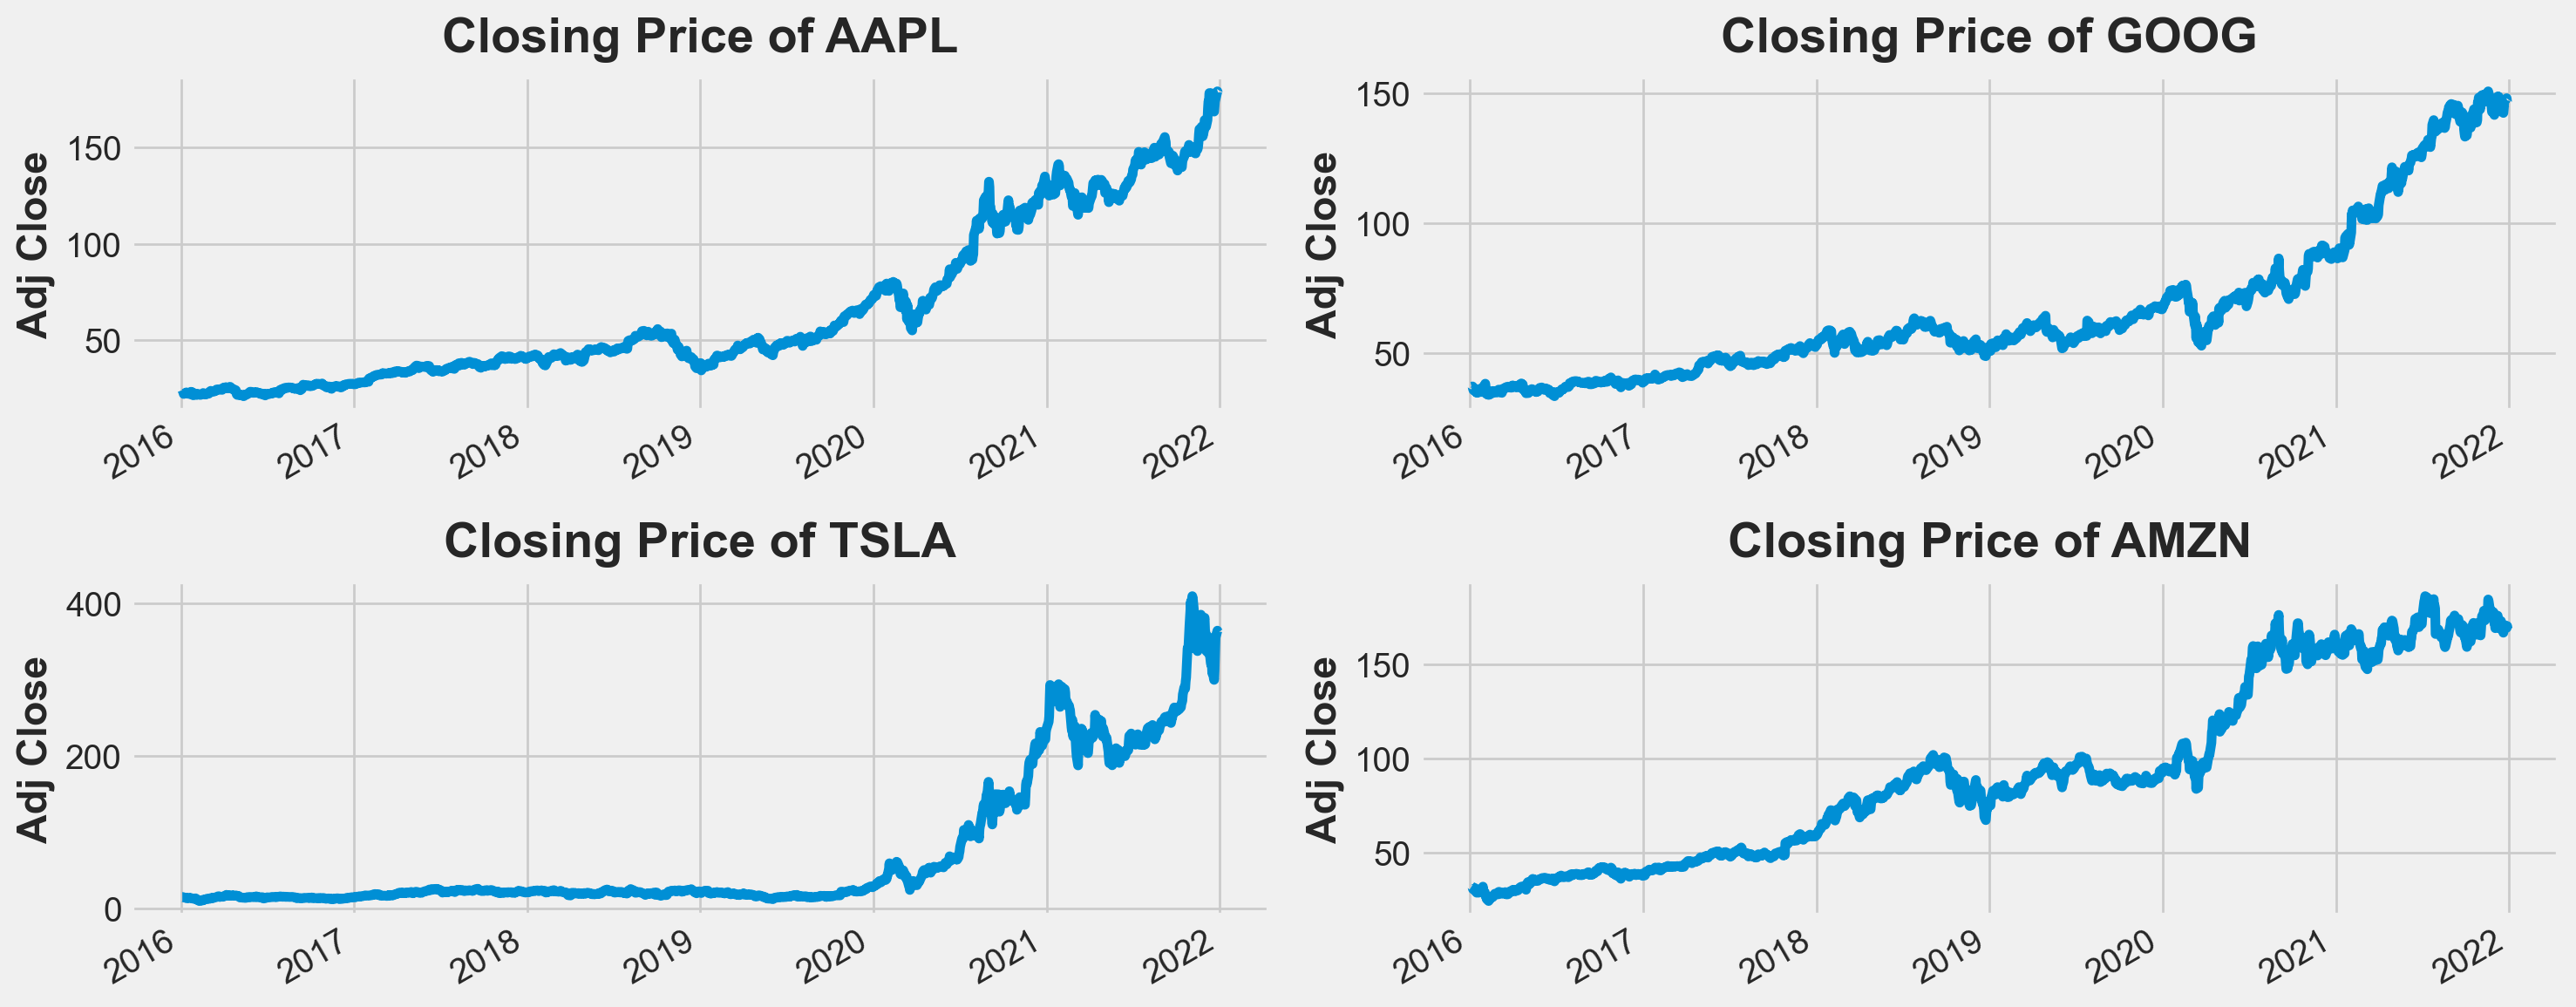

In [415]:
# Let's see a historical view of the closing price


plt.figure(figsize=(15, 6))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Adj Close'].plot()
    plt.ylabel('Adj Close')
    plt.xlabel(None)
    plt.title(f"Closing Price of {tech_list[i - 1]}")
    
plt.tight_layout()

# First analysis of time dependance on AMAZON

In [416]:
df['Time'] = np.arange(len(df.index))

df.head()
df.columns
filter_am = df["company_name"]=="TESLA"
df_am = df[filter_am]
df_am.head()

,Open,High,Low,Close,Adj Close,Volume,company_name,Time
Date,,,,,,,,
2016-01-04,15.381333,15.425333,14.600000,14.894000,14.894000,102406500,TESLA,3018
2016-01-05,15.090667,15.126000,14.666667,14.895333,14.895333,47802000,TESLA,3019
2016-01-06,14.666667,14.670000,14.398667,14.602667,14.602667,56686500,TESLA,3020
2016-01-07,14.279333,14.562667,14.244667,14.376667,14.376667,53314500,TESLA,3021
2016-01-08,14.524000,14.696000,14.051333,14.066667,14.066667,54421500,TESLA,3022


In [417]:
from sklearn.linear_model import LinearRegression

# Training data
X = df_am.loc[:, ['Time']]  # features
y = df_am.loc[:, 'Close']  # target

# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index=X.index)


/var/folders/y9/x007ynb92t57yt7s517ct53w0000gn/T/ipykernel_76461/1151102424.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")
/Users/olivier_ld/Library/Python/3.10/lib/python/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


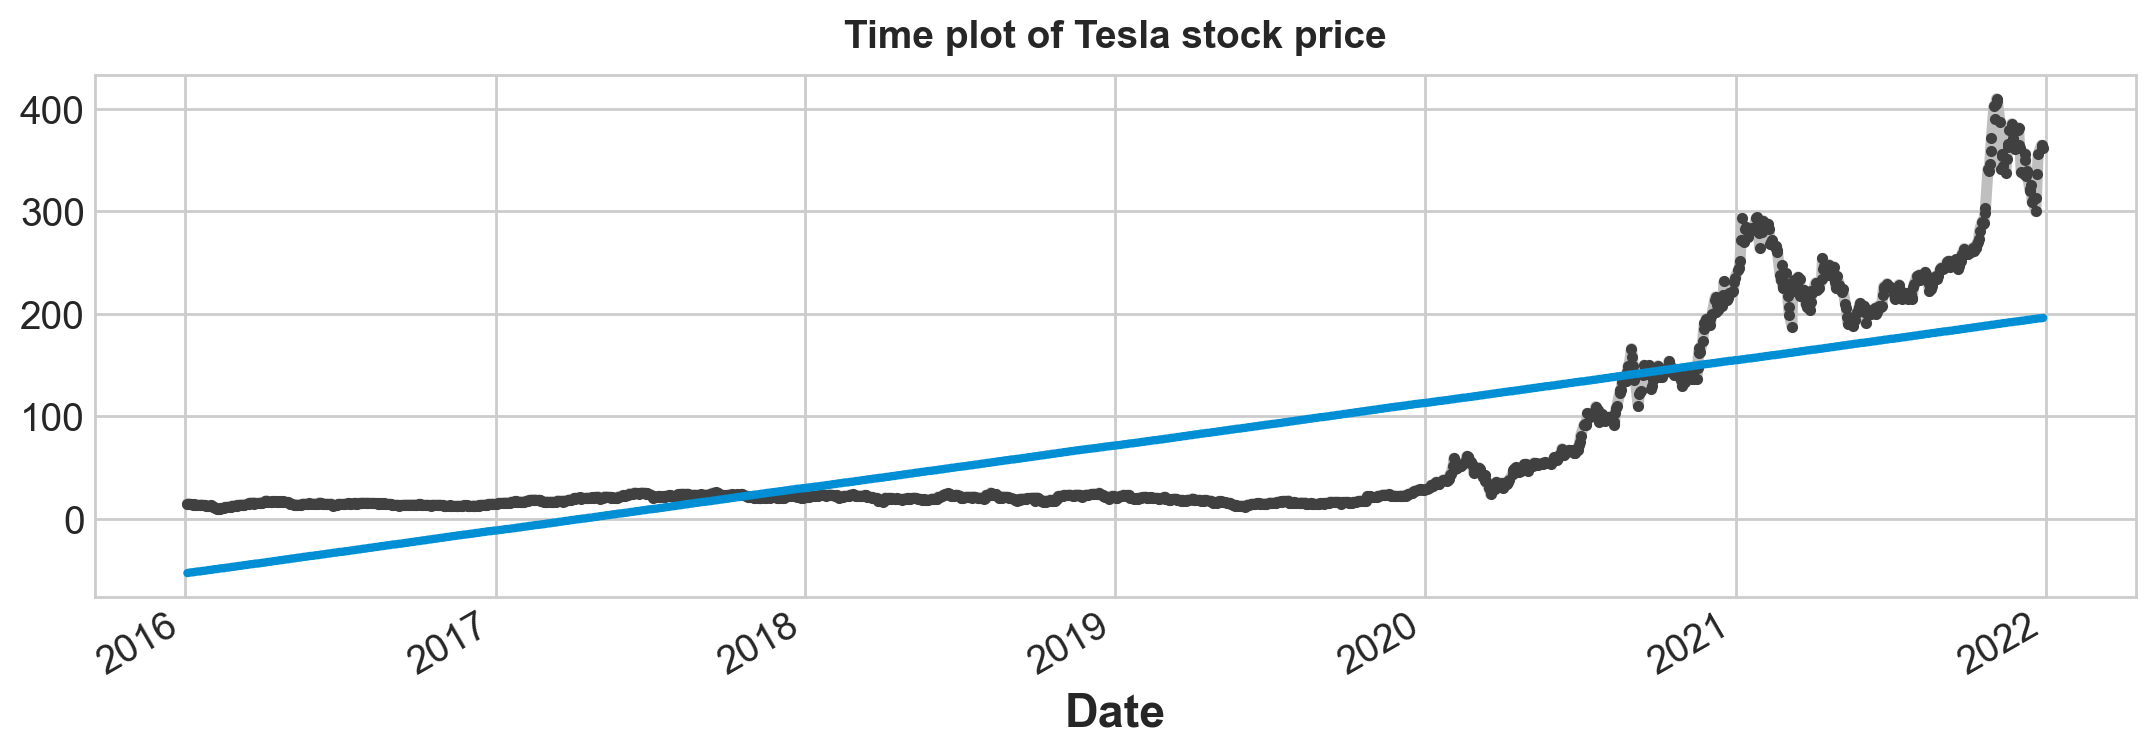

In [418]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'
ax = y.plot(**plot_params)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time plot of Tesla stock price');

In [419]:
#adding a lag feature
df_am['Lag_1'] = df_am['Close'].shift(1)
df_am.head()

X = df_am.loc[:, ['Lag_1']]
X.dropna(inplace=True)  # drop missing values in the feature set
y = df_am.loc[:, 'Close']  # create the target
y, X = y.align(X, join='inner')  # drop corresponding values in target

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

/var/folders/y9/x007ynb92t57yt7s517ct53w0000gn/T/ipykernel_76461/2268713015.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_am['Lag_1'] = df_am['Close'].shift(1)


/Users/olivier_ld/Library/Python/3.10/lib/python/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


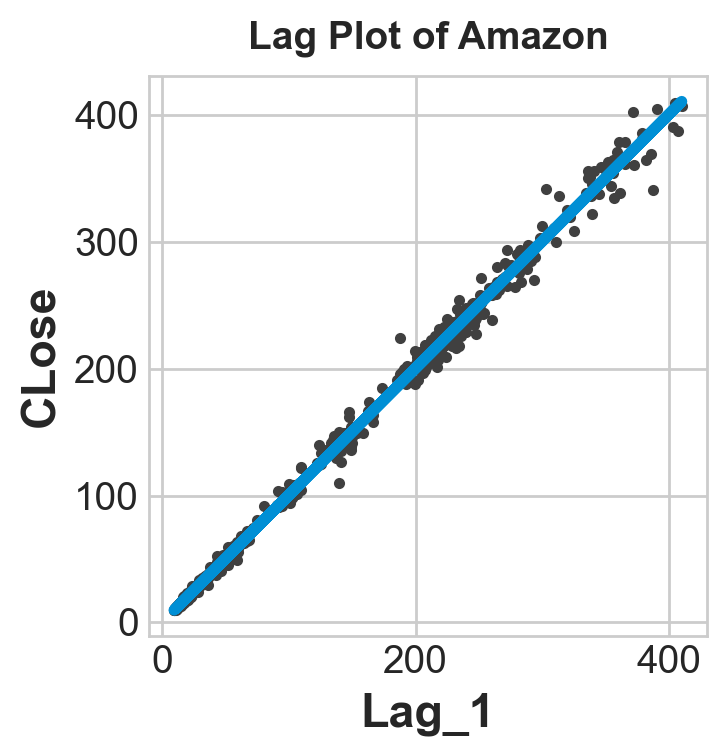

In [420]:
fig, ax = plt.subplots()
ax.plot(X['Lag_1'], y, '.', color='0.25')
ax.plot(X['Lag_1'], y_pred)
ax.set_aspect('equal')
ax.set_ylabel('CLose')
ax.set_xlabel('Lag_1')
ax.set_title('Lag Plot of Amazon');

#  Check for seasonality

/var/folders/y9/x007ynb92t57yt7s517ct53w0000gn/T/ipykernel_76461/1993479307.py:65: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  X["week"] = X.index.week  # the seasonal period (period)
/var/folders/y9/x007ynb92t57yt7s517ct53w0000gn/T/ipykernel_76461/1993479307.py:37: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  ax = sns.lineplot(
/var/folders/y9/x007ynb92t57yt7s517ct53w0000gn/T/ipykernel_76461/1993479307.py:37: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  ax = sns.lineplot(
/var/folders/y9/x007ynb92t57yt7s517ct53w0000gn/T/ipykernel_76461/1993479307.py:3: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be remov

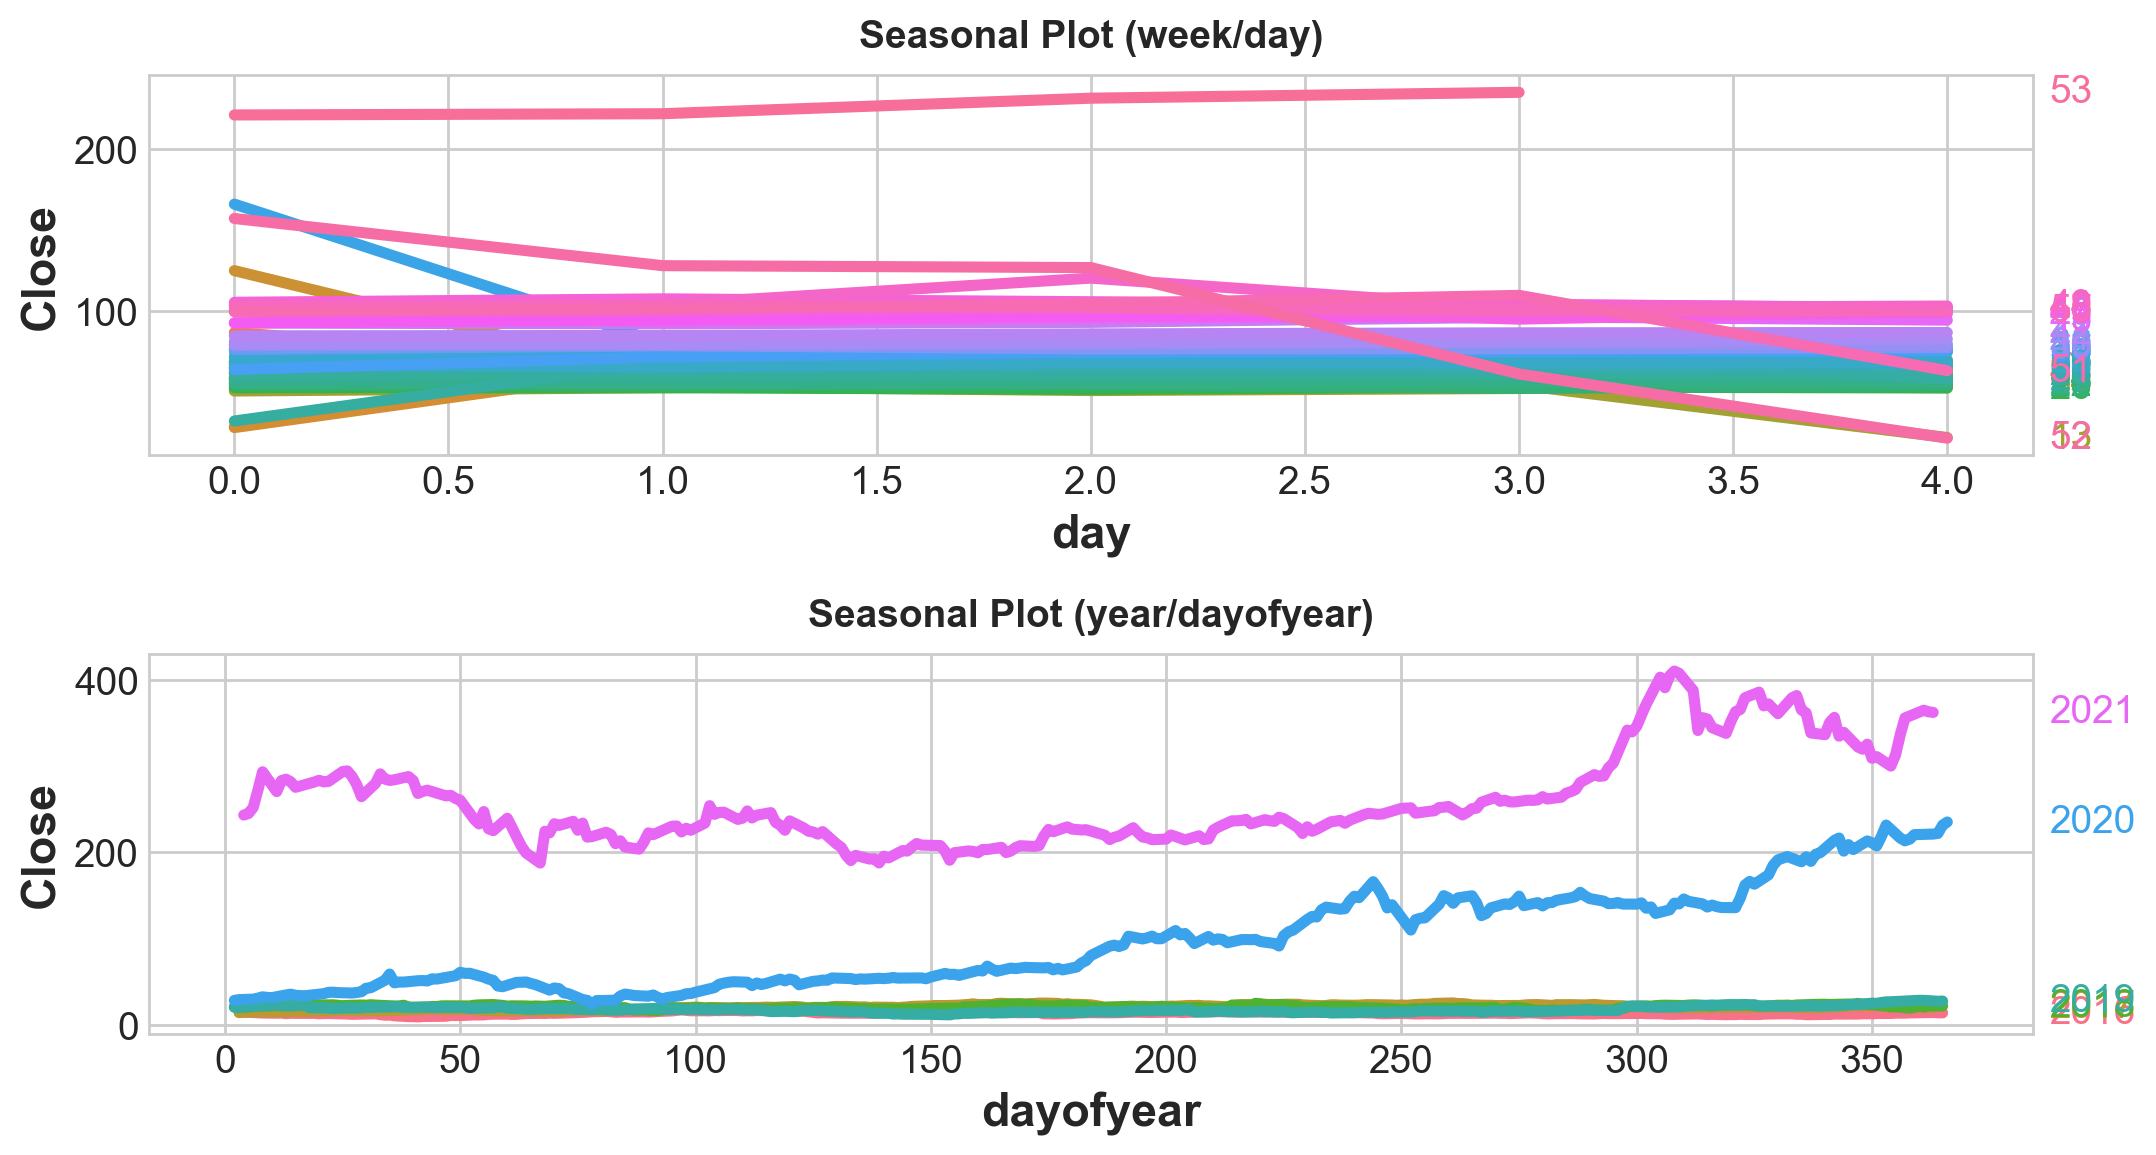

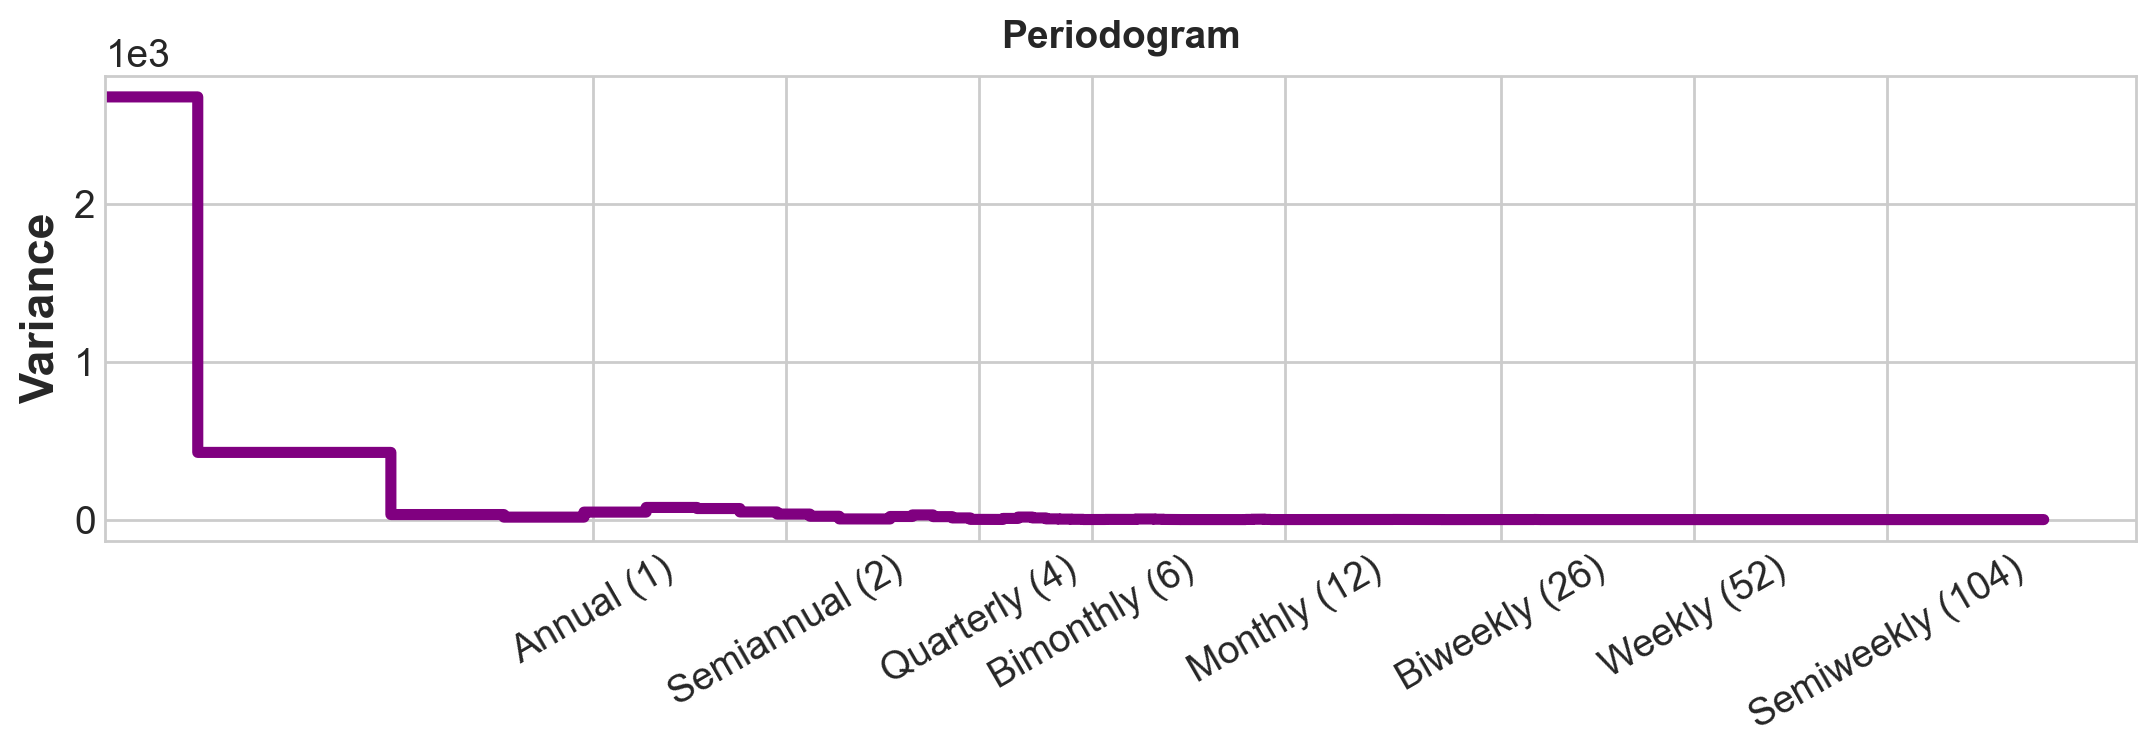

In [421]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax
X = df_am.copy()

# days within a week
X["day"] = X.index.dayofweek  # the x-axis (freq)
X["week"] = X.index.week  # the seasonal period (period)

# days within a year
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X, y="Close", period="week", freq="day", ax=ax0)
seasonal_plot(X, y="Close", period="year", freq="dayofyear", ax=ax1);

plot_periodogram(df_am.Close);

# Multistep Forecasting Strategies of Tesla

Linear regression excels at extrapolating trends, but can't learn interactions.

In [422]:
filter_gg = df["company_name"]=="TESLA"
df_gg = df[filter_gg]
df_gg = df_gg.drop('Open', axis=1)
df_gg = df_gg.drop('High', axis=1)
df_gg = df_gg.drop('Low', axis=1)
df_gg = df_gg.drop('Adj Close', axis=1)
df_gg = df_gg.drop('Volume', axis=1)
df_gg = df_gg.drop('company_name', axis=1)
df_gg = df_gg.drop('Time', axis=1)


#Test set
# start_date = '2010-01-01'
# end_date = '2019-12-30'
# mask = (df_gg['birth_date'] & gt= start_date) & amp (df_gg['birth_date'] & lt= end_date)
# df_gg_test = df_gg.loc[mask]
# df_gg_test.head()

df_gg_test = df_gg
df_gg_test.head()


,Close
Date,
2016-01-04,14.894000
2016-01-05,14.895333
2016-01-06,14.602667
2016-01-07,14.376667
2016-01-08,14.066667


In [423]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)



/var/folders/y9/x007ynb92t57yt7s517ct53w0000gn/T/ipykernel_76461/81967786.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


/var/folders/y9/x007ynb92t57yt7s517ct53w0000gn/T/ipykernel_76461/2039074377.py:38: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
/var/folders/y9/x007ynb92t57yt7s517ct53w0000gn/T/ipykernel_76461/2039074377.py:39: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  axs = y_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
/var/folders/y9/x007ynb92t57yt7s517ct53w0000gn/T/ipykernel_76461/2039074377.py:40: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  axs = y_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
/Users/olivier_ld/Library/Python/3.10/lib/python/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_la

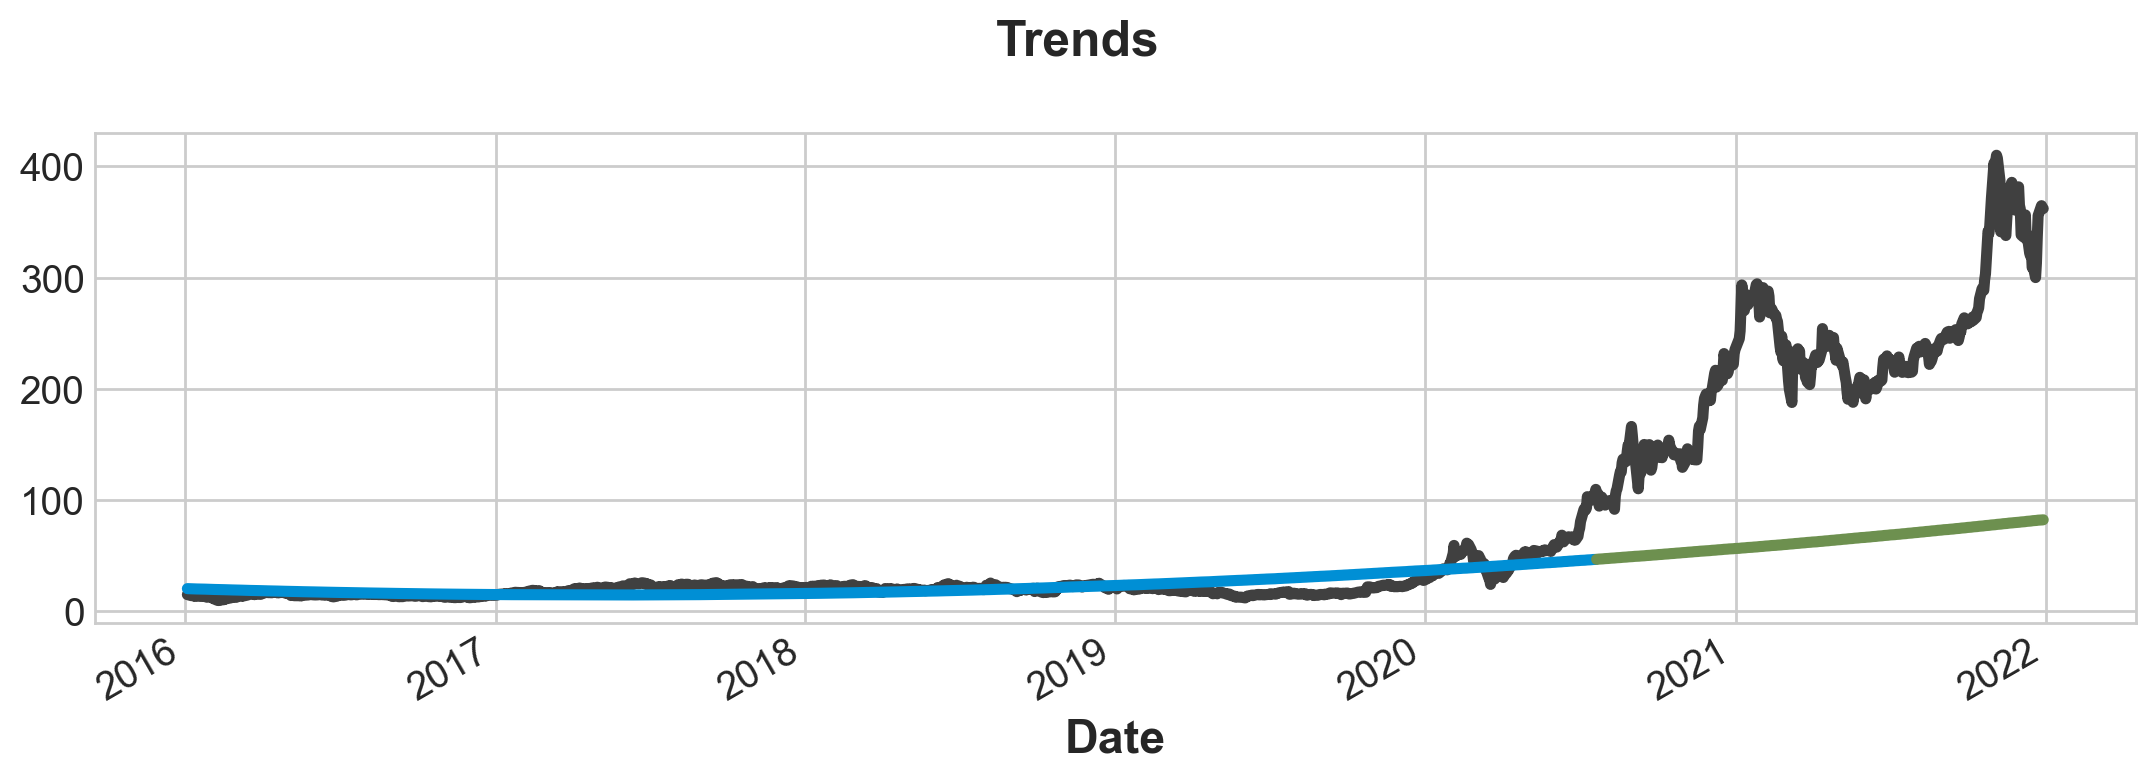

In [424]:
y = df_gg_test

# Create trend features
dp = DeterministicProcess(
    index=y.index,  # dates from the training data
    constant=True,  # the intercept
    order=2,        # quadratic trend
    drop=True,      # drop terms to avoid collinearity
)
X = dp.in_sample()  # features for the training data

# Test on the years 2016-2019. It will be easier for us later if we
# split the date index instead of the dataframe directly.
idx_train, idx_test = train_test_split(
    y.index, test_size=365, shuffle=False,
)
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

# Fit trend model
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

# Make predictions
y_fit = pd.DataFrame(
    model.predict(X_train),
    index=y_train.index,
    columns=y_train.columns,
)
y_pred = pd.DataFrame(
    model.predict(X_test),
    index=y_test.index,
    columns=y_test.columns,
)

# Plot
axs = y_train.plot(color='0.25', subplots=True, sharex=True)
axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Trends")

In [425]:
# The `stack` method converts column labels to row labels, pivoting from wide format to long
X = df_gg_test  # pivot dataset wide to long
display(X.head())
y = X.pop('Close')

,Close
Date,
2016-01-04,14.894000
2016-01-05,14.895333
2016-01-06,14.602667
2016-01-07,14.376667
2016-01-08,14.066667


In [426]:
# Turn row labels into categorical feature columns with a label encoding
# X = X.reset_index('Industries')
# Label encoding for 'Industries' feature
# for colname in X.select_dtypes(["object", "category"]):
#     X[colname], _ = X[colname].factorize()

# Label encoding for annual seasonality
X["Days"] = X.index.day  # values are 1, 2, ..., 31


# Create splits
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

print(y_train)
print(X_train)
print(y_fit)

Date
2016-01-04     14.894000
2016-01-05     14.895333
2016-01-06     14.602667
2016-01-07     14.376667
2016-01-08     14.066667
                 ...    
2020-07-14    101.120003
2020-07-15    103.067329
2020-07-16    100.042664
2020-07-17    100.056000
2020-07-20    109.533333
Name: Close, Length: 1144, dtype: float64
            Days
Date            
2016-01-04     4
2016-01-05     5
2016-01-06     6
2016-01-07     7
2016-01-08     8
...          ...
2020-07-14    14
2020-07-15    15
2020-07-16    16
2020-07-17    17
2020-07-20    20

[1144 rows x 1 columns]
                Close
Date                 
2016-01-04  20.277873
2016-01-05  20.244333
2016-01-06  20.210892
2016-01-07  20.177550
2016-01-08  20.144307
...               ...
2020-07-14  46.232680
2020-07-15  46.311894
2020-07-16  46.391207
2020-07-17  46.470619
2020-07-20  46.550130

[1144 rows x 1 columns]


In [427]:
# Pivot wide to long (stack) and convert DataFrame to Series (squeeze)
y_fit = y_fit.stack().squeeze()    # trend from training set
y_pred = y_pred.stack().squeeze()  # trend from test set

# Create residuals (the collection of detrended series) from the training set
y_resid = y_train - y_fit

# Train XGBoost on the residuals
xgb = XGBRegressor()
xgb.fit(X_train, y_resid)

# Add the predicted residuals onto the predicted trends
y_fit_boosted = xgb.predict(X_train) + y_fit
y_pred_boosted = xgb.predict(X_test) + y_pred

In [428]:
# print(y_pred_boosted)
print(y_train)
print(y_fit)
print(y_resid)
print(y_fit_boosted)

Date
2016-01-04     14.894000
2016-01-05     14.895333
2016-01-06     14.602667
2016-01-07     14.376667
2016-01-08     14.066667
                 ...    
2020-07-14    101.120003
2020-07-15    103.067329
2020-07-16    100.042664
2020-07-17    100.056000
2020-07-20    109.533333
Name: Close, Length: 1144, dtype: float64
Date             
2016-01-04  Close    20.277873
2016-01-05  Close    20.244333
2016-01-06  Close    20.210892
2016-01-07  Close    20.177550
2016-01-08  Close    20.144307
                       ...    
2020-07-14  Close    46.232680
2020-07-15  Close    46.311894
2020-07-16  Close    46.391207
2020-07-17  Close    46.470619
2020-07-20  Close    46.550130
Length: 1144, dtype: float64
Date             
2016-01-04  Close    -5.383873
2016-01-05  Close    -5.349000
2016-01-06  Close    -5.608225
2016-01-07  Close    -5.800883
2016-01-08  Close    -6.077640
                       ...    
2020-07-14  Close    54.887322
2020-07-15  Close    56.755435
2020-07-16  Close    53.

/Users/olivier_ld/Library/Python/3.10/lib/python/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


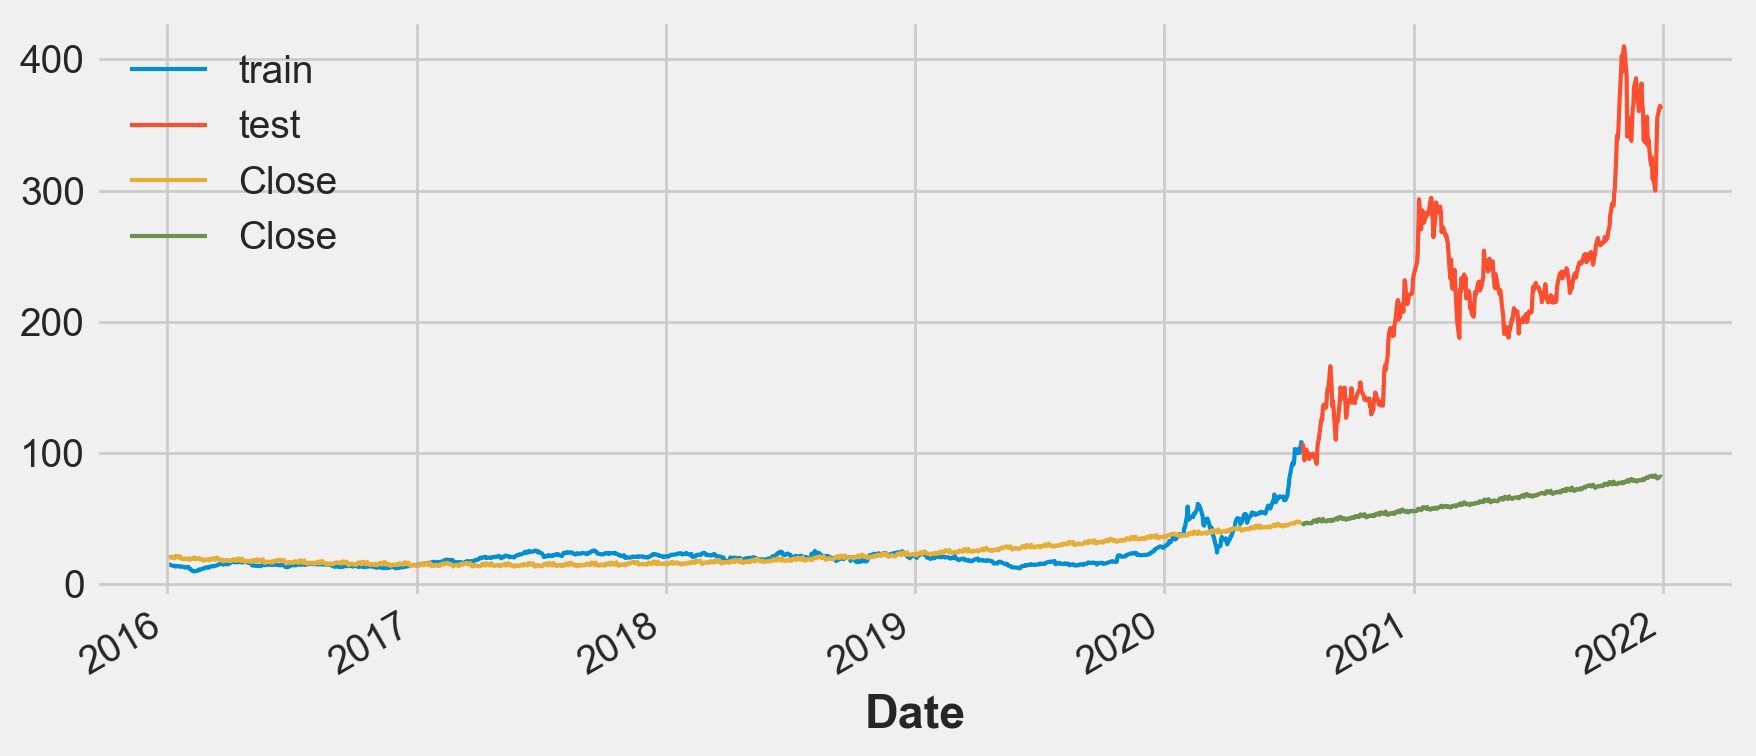

In [429]:
# import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline


fig, ax = plt.subplots(figsize=(9, 4))
y_train.plot(ax=ax, label='train')
y_test.plot(ax=ax, label='test')
y_fit_boosted.unstack().plot(ax=ax, label='train')
y_pred_boosted.unstack().plot(ax=ax, label='test')
ax.legend();

/var/folders/y9/x007ynb92t57yt7s517ct53w0000gn/T/ipykernel_76461/4047778591.py:5: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  axs = y_test.plot(
/var/folders/y9/x007ynb92t57yt7s517ct53w0000gn/T/ipykernel_76461/4047778591.py:8: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  axs = y_fit_boosted.unstack().plot(
/var/folders/y9/x007ynb92t57yt7s517ct53w0000gn/T/ipykernel_76461/4047778591.py:11: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  axs = y_pred_boosted.unstack().plot(
/Users/olivier_ld/Library/Python/3.10/lib/python/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


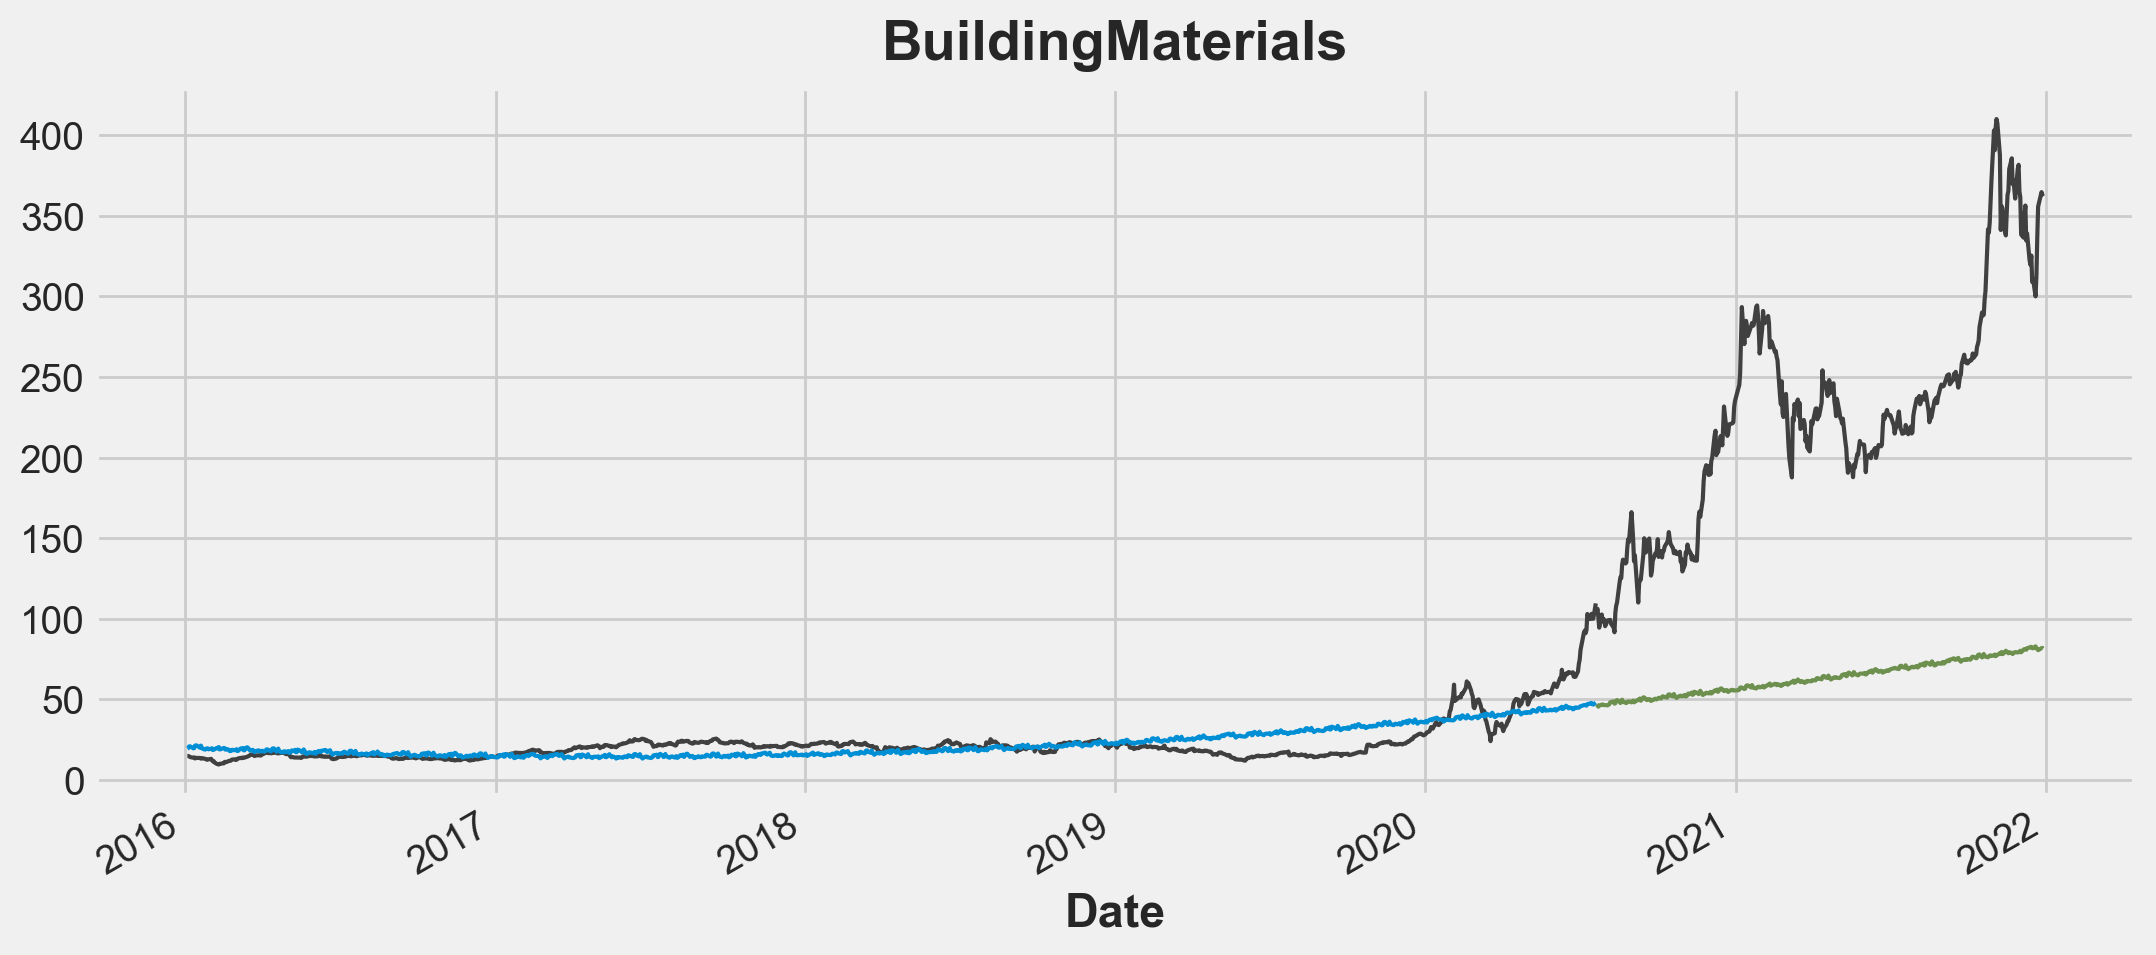

In [430]:
axs = y_train.plot(
    color='0.25', figsize=(11, 5), subplots=True, sharex=True,
    title=['BuildingMaterials'],
)
axs = y_test.plot(
    color='0.25', subplots=True, sharex=True, ax=axs,
)
axs = y_fit_boosted.unstack().plot(
    color='C0', subplots=True, sharex=True, ax=axs,
)
axs = y_pred_boosted.unstack().plot(
    color='C3', subplots=True, sharex=True, ax=axs,
)
for ax in axs: ax.legend([])